In [1]:
import glob
import numpy as np
import rasterio
import torch
import torch.nn.functional as F

from PatchDataloader import PatchDataset
import overlap_cluster

import tqdm
import matplotlib.pyplot as plt

## Compute Overlap Clustering

In [2]:
device = torch.device('cuda:0')

# Specify tiles
naip_paths = glob.glob('data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/*naip.tif')
naip_paths.sort()

n_clusters = 5
for i, path in enumerate(naip_paths):
    print(f'[{i+1}/{len(naip_paths)}] {path}')
    # Load NAIP
    with rasterio.open(path, 'r') as src:
        prof = src.profile
        naip = src.read()
    
    # First downsample the full tile
    naip_down = F.avg_pool2d(torch.from_numpy(naip).float().unsqueeze(0) / 255., kernel_size=7, stride=4, padding=3).squeeze(0).numpy()
        
    # Run overlap clustering -- hyperparameters can vary from location to laction
    p,mean,var,prior = overlap_cluster.run_clustering(naip_down, n_classes=5, radius=15, n_iter=30, stride=1, warmup_steps=0, warmup_radius=0, device=device)
    
    clusters = np.argmax(p, axis=0)[np.newaxis,:,:]
    clusters = F.interpolate(torch.from_numpy(clusters).float().unsqueeze(0), scale_factor=4, mode='nearest').squeeze(0).numpy()
    
    # Save result
    oc_path = ''.join(path.split('.tif')[:-1] + ['_oc.tif'])
    prof['count'] = 1
    with rasterio.open(oc_path, 'w', **prof) as dst:
        dst.write(clusters.astype(np.uint8))
    print('Saved at', oc_path)
    

[1/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311117_sw_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311117_sw_a_naip_oc.tif
[2/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311127_sw_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.36it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311127_sw_a_naip_oc.tif
[3/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311133_nw_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.33it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311133_nw_a_naip_oc.tif
[4/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311215_sw_a_naip.tif


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311215_sw_a_naip_oc.tif
[5/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_ne_a_naip.tif


100%|██████████| 30/30 [00:07<00:00,  4.26it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_ne_a_naip_oc.tif
[6/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_se_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_se_a_naip_oc.tif
[7/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_sw_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.30it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311223_sw_a_naip_oc.tif
[8/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311224_ne_a_naip.tif


100%|██████████| 30/30 [00:06<00:00,  4.32it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311224_ne_a_naip_oc.tif
[9/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_se_a_naip.tif


100%|██████████| 30/30 [00:07<00:00,  4.28it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_se_a_naip_oc.tif
[10/10] data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_sw_a_naip.tif


100%|██████████| 30/30 [00:07<00:00,  4.25it/s]


Saved at data/enviroatlas_lotp/phoenix_az-2010_1m-test_tiles-debuffered/3311228_sw_a_naip_oc.tif


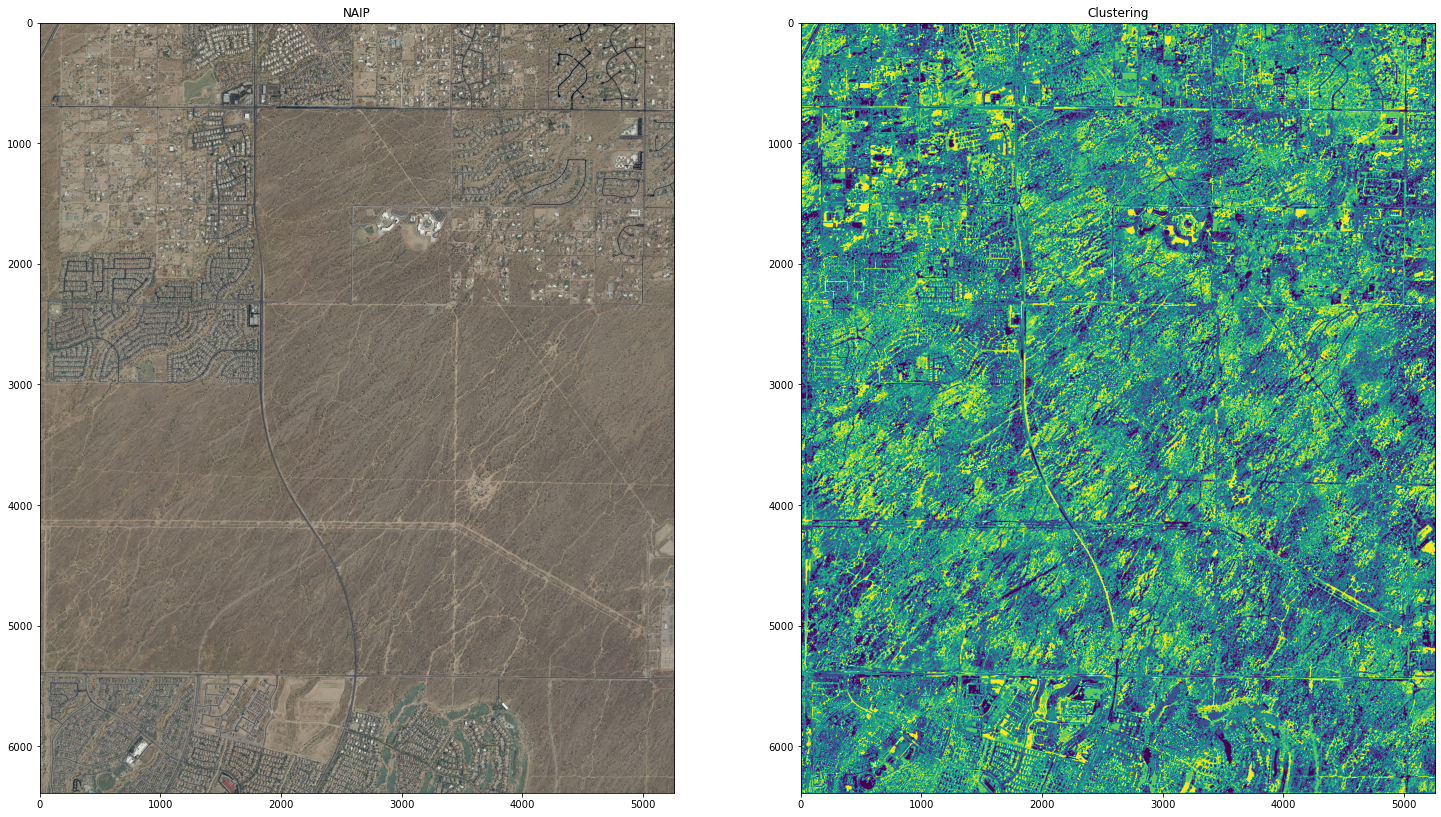

In [4]:
# Plot NAIP and computed Overlap Clustering
oc_paths = glob.glob('data/enviroatlas_lotp/phoenix_az-2010_1m-val5_tiles-debuffered/*naip_oc.tif')
oc_paths.sort()
idx = 0

with rasterio.open(naip_paths[idx], 'r') as src:
    naip = src.read()
with rasterio.open(oc_paths[idx], 'r') as src:
    oc = src.read()
    
fig, ax = plt.subplots(1, 2, figsize=(25,15))
ax[0].imshow(naip.transpose([1,2,0])[:,:,:3])
ax[0].set_title('NAIP')

ax[1].imshow(oc.transpose([1,2,0]))
ax[1].set_title('Clustering')
plt.show()